<h1>Table of Contents<span class="tocSkip"></span></h1>


# Introduction

Our client is a real estate investment firm that would like  to break into the Texas housing market. The firm has asked us to identify the top 5 zip codes thye should invest in to ensure investment success.

# Data importation & cleaning

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from pandas import Grouper
from pandas import Series
from pandas import concat
import statsmodels.api as sm
from statsmodels.tsa.arima.model import  ARIMA
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
import warnings

In [2]:
# import data
raw_df = pd.read_csv('data/zillow_data.csv')
df_income = pd.read_csv('data/zip_codes_2019_median_inc.csv')

## Cleaning column names

In [3]:
raw_df.columns = raw_df.columns.str.strip().str.lower()
df_income.columns = df_income.columns.str.strip().str.lower()

In [4]:
raw_df.rename(columns={'regionname': 'zipcode', 'countyname':'county'},inplace=True)
df_income.rename(columns={
    'zip code':'zipcode', 'population (2019)': 'population',
    'median family income (2019)': 'median_family_income'},
                 inplace=True)

## Stratifying to Texas

We begin to narrow down our dataset, first by filtering to only data from the state of Texas

In [5]:
raw_df = raw_df[raw_df['state']=='TX']
df_income['state'] = df_income['preferred name'].str.slice(-2)
df_income = df_income[df_income['state']=='TX']
df_income = (df_income[df_income['type'] != 'PO box'])

## Creating statistical columns

create ROI, Standard Deviation, Mean, and Coefficient of Variance statistical columns

In [6]:
#Calculate historical return on investment
raw_df['ROI']= (raw_df['2018-04']/raw_df['1996-04'])-1
raw_df['ROI']


#Calculate standard deviation of monthly values
raw_df['std']=raw_df.loc[:,'1996-04':'2018-04'].std(skipna=True, axis=1)

#Calculate historical mean value
raw_df['mean']=raw_df.loc[:,'1996-04':'2018-04'].mean(skipna=True, axis=1)

 
#Show calculated values
raw_df[['zipcode','std','mean','ROI']].head()

warnings.filterwarnings('ignore')

In [7]:
# RegionID is something from Zillow, don't need it and we don't need state any more.
raw_df.drop(['regionid', 'sizerank', 'metro'], axis=1,inplace=True)

In [8]:
# we only want zipcode, pop, mfi, lat and long from 2019 income data
df_income = df_income[df_income.columns[np.r_[0,5,7,9:11]]]
df_income

,zipcode,population,median_family_income,latitude,longitude
31142,73301,NaN,NaN,NaN,NaN
31143,73344,NaN,NaN,NaN,NaN
31744,75001,"14,992","$79,551",32.959999,-96.838997
31745,75002,"71,253","$105,656",33.090000,-96.609001
31746,75006,"51,642","$72,325",32.962002,-96.899002
...,...,...,...,...,...
34257,79961,NaN,NaN,NaN,NaN
34258,79968,NaN,NaN,NaN,NaN
34259,79976,NaN,NaN,NaN,NaN
34260,79978,NaN,NaN,NaN,NaN


In [9]:
# fixing mfi and pop columns
df_income['median_family_income'] = df_income['median_family_income'].str.strip('$\n\t')
df_income['median_family_income'] = df_income['median_family_income'].str.replace(',','')
df_income = df_income[df_income['median_family_income'].notna()]
df_income['median_family_income'] = df_income['median_family_income'].astype(int)
df_income['population'] = df_income['population'].str.replace(',','')
df_income['population'] = df_income['population'].astype(int)

## Melting our df

In [10]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['zipcode', 'city', 'state', 'county','ROI','std','mean'], var_name='date')
    melted['date'] = pd.to_datetime(melted['date'], infer_datetime_format=True)
    melted['year'] = [d.year for d in melted.date]
    melted = melted.dropna(subset=['value'])
    return melted

In [11]:
df = melt_data(raw_df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255096 entries, 0 to 262084
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   zipcode  255096 non-null  int64         
 1   city     255096 non-null  object        
 2   state    255096 non-null  object        
 3   county   255096 non-null  object        
 4   ROI      250160 non-null  float64       
 5   std      255096 non-null  float64       
 6   mean     255096 non-null  float64       
 7   date     255096 non-null  datetime64[ns]
 8   value    255096 non-null  float64       
 9   year     255096 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(3)
memory usage: 21.4+ MB


In [12]:
df.set_index(df['date'], inplace = True)
df.drop('date',axis=1, inplace=True)
df

,zipcode,city,state,county,ROI,std,mean,value,year
date,,,,,,,,,
1996-04-01,75070,McKinney,TX,Collin,0.365295,33537.101427,219655.849057,235700.0,1996
1996-04-01,77494,Katy,TX,Harris,0.567966,37730.794353,262110.566038,210400.0,1996
1996-04-01,79936,El Paso,TX,El Paso,0.571798,18167.079218,101875.471698,77300.0,1996
1996-04-01,77084,Houston,TX,Harris,0.729474,17242.109812,121185.283019,95000.0,1996
1996-04-01,77449,Katy,TX,Harris,0.846960,18603.288493,126530.188679,95400.0,1996
...,...,...,...,...,...,...,...,...,...
2018-04-01,76941,Mertzon,TX,Irion,NaN,13734.029878,99318.367347,121600.0,2018
2018-04-01,79313,Anton,TX,Hockley,NaN,5286.674724,54424.675325,63300.0,2018
2018-04-01,79355,Plains,TX,Yoakum,NaN,12929.465872,78967.346939,93500.0,2018


# Merging our data

In [13]:
df_merged = df.reset_index().merge(df_income, how='left').set_index('date')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 255096 entries, 1996-04-01 to 2018-04-01
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   zipcode               255096 non-null  int64  
 1   city                  255096 non-null  object 
 2   state                 255096 non-null  object 
 3   county                255096 non-null  object 
 4   ROI                   250160 non-null  float64
 5   std                   255096 non-null  float64
 6   mean                  255096 non-null  float64
 7   value                 255096 non-null  float64
 8   year                  255096 non-null  int64  
 9   population            252181 non-null  float64
 10  median_family_income  252181 non-null  float64
 11  latitude              252181 non-null  float64
 12  longitude             252181 non-null  float64
dtypes: float64(8), int64(2), object(3)
memory usage: 27.2+ MB


In [14]:
# creating a separate df_merged to save this data for later
df_merged_for_later = df_merged

## Filtering on population

In [15]:
df_upper = df_merged['population'].quantile(.75)
df_filtered_pop = df_merged[(df_merged['population'] > df_upper)]

## Filtering on house value percentile

In [16]:
# Select the first quantile
q1 = df_filtered_pop['value'].quantile(.25)

# Select the third quantile
q3 = df_filtered_pop['value'].quantile(.75)


# Create a filtered in between q1 & q3
filtered = df_filtered_pop[(df_filtered_pop['value']>=q1) 
             & (df_filtered_pop['value']<=q3)]
df_filtered_iqr = pd.DataFrame(filtered)
df_filtered_iqr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31421 entries, 1996-04-01 to 2018-04-01
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   zipcode               31421 non-null  int64  
 1   city                  31421 non-null  object 
 2   state                 31421 non-null  object 
 3   county                31421 non-null  object 
 4   ROI                   31421 non-null  float64
 5   std                   31421 non-null  float64
 6   mean                  31421 non-null  float64
 7   value                 31421 non-null  float64
 8   year                  31421 non-null  int64  
 9   population            31421 non-null  float64
 10  median_family_income  31421 non-null  float64
 11  latitude              31421 non-null  float64
 12  longitude             31421 non-null  float64
dtypes: float64(8), int64(2), object(3)
memory usage: 3.4+ MB


In [17]:
# group by date and aggregate on median value
df_filtered_iqr['median_house_price'] = df_filtered_iqr.groupby('date').aggregate({'value':'median'})
df_filtered_iqr['affordability'] = df_filtered_iqr['value'] - df_filtered_iqr['median_family_income']/.12

## Filtering on affordability score

Affordability Score is a metric to represent the ability for a resident to pay their mortgage.

It is based off two assumptions:

    1.Your yearly mortgage should be ~30% of your annual salary
    2.It's a 30 year mortgage

In [18]:
# create function to normalize data
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
df_filtered_iqr['affordability_score']  = normalize_data(df_filtered_iqr['affordability'])

In [19]:
# filtering to the 20th percentile
top_20 = df_filtered_iqr['affordability_score'].quantile(.5)
df_filtered_afs = df_filtered_iqr[(df_filtered_iqr['affordability_score'] < top_20)]
df_filtered_afs.reset_index().isna().sum()

date                    0
zipcode                 0
city                    0
state                   0
county                  0
ROI                     0
std                     0
mean                    0
value                   0
year                    0
population              0
median_family_income    0
latitude                0
longitude               0
median_house_price      0
affordability           0
affordability_score     0
dtype: int64

## Filtering for 2017-2018

In [20]:
df_filtered_2017 = df_filtered_afs['2017-01-01':].dropna()

### Sort by highest ROI

In [21]:
df_filtered_2017 = df_filtered_2017.reset_index()
df_filtered_top_roi = df_filtered_2017.loc[df_filtered_2017.groupby("zipcode")["ROI"].idxmax()].sort_values('ROI',axis=0,ascending=False)[:5]
df_filtered_top_roi.set_index('date',inplace=True)
df_filtered_top_roi

,zipcode,city,state,county,ROI,std,mean,value,year,population,median_family_income,latitude,longitude,median_house_price,affordability,affordability_score
date,,,,,,,,,,,,,,,,
2017-01-01,79423,Lubbock,TX,Lubbock,1.082037,21451.329003,105156.226415,139000.0,2017,40303.0,82989.0,33.439999,-101.855003,145050.0,-552575.000000,0.552195
2017-01-01,77571,La Porte,TX,Harris,1.040936,20507.800452,116197.358491,153100.0,2017,37427.0,85150.0,29.688000,-95.056999,145050.0,-556483.333333,0.548188
2017-01-01,76108,Fort Worth,TX,Tarrant,1.013480,17152.126989,106005.660377,143500.0,2017,43169.0,80040.0,32.787998,-97.524002,145050.0,-523500.000000,0.582005
2017-01-01,75052,Grand Prairie,TX,Dallas,0.995040,19370.586349,134230.188679,176200.0,2017,95495.0,85220.0,32.665001,-97.025002,145050.0,-533966.666667,0.571274
2017-01-01,75104,Cedar Hill,TX,Dallas,0.954222,18302.905606,129367.924528,166100.0,2017,49171.0,83143.0,32.580002,-96.964996,145050.0,-526758.333333,0.578664


# EDA on Best Zipcodes

## Pulling out best zips

In [22]:
zipcodes = list(df_filtered_top_roi['zipcode'].values)
zipcodes

[79423, 77571, 76108, 75052, 75104]

In [23]:
df_filtered_top_roi = df_filtered_top_roi[df_filtered_top_roi['zipcode'].isin(zipcodes)]

`df_zip_5` is filtered for the top 5 zip codes.

Each unique row represents a combination of unique month and zip code.

In [24]:
df_zip_5 = df_merged[df_merged['zipcode'].isin(zipcodes)]

In [25]:
df_zip_5['zipcode'].value_counts()

76108    265
75052    265
75104    265
79423    265
77571    265
Name: zipcode, dtype: int64

## Unstack zips

`df_prices` will unstack zips through a pivot function.

Its values represent the home prices per month.

In [26]:
df_prices = pd.DataFrame(df_zip_5[['zipcode','value']], index = df_zip_5.index)
df_prices.reset_index(inplace=True)

df_prices = df_prices.pivot('date', 'zipcode', 'value')
df_prices

zipcode,75052,75104,76108,77571,79423
date,,,,,
1996-04-01,100800.0,98300.0,81600.0,85500.0,70700.0
1996-05-01,100900.0,98500.0,81500.0,85600.0,70900.0
1996-06-01,101000.0,98700.0,81400.0,85800.0,71200.0
1996-07-01,101000.0,99000.0,81400.0,85900.0,71500.0
1996-08-01,101200.0,99200.0,81400.0,86000.0,71800.0
...,...,...,...,...,...
2017-12-01,194300.0,184400.0,158300.0,170300.0,147900.0
2018-01-01,195200.0,187000.0,160100.0,171800.0,148200.0
2018-02-01,196700.0,189100.0,161900.0,173100.0,148200.0


# Modeling on Each Zipcode

In each model, we split the zipcode data so we train on prices from April 1996 - April 2016 and test on prices from May 2016 - April 2018

## Defining Stationarity, TS Metrics, and Plot Functions

In [27]:
def stationarity_check(df):     
    df_test = adfuller(df)
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in df_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    return None

In [50]:
def arima_results(endog, test, order=[0,0,0]):
    endog= train.astype('float32')  
    test = test.astype('float32')  
    arima = ARIMA(endog, order=order)
    
    arima.fit()
    
#     train_hat = arima.predict()
    
    rmse_train = mean_squared_error(endog,
                                    arima.predict(endog.index[0], endog.index[-1] 
                                        ),
                                    squared=False)
    
    
    rmse_test = mean_squared_error(test,
                                   arima.predict(test.index[0], test.index[-1]), 
                                   squared=False)
    
 
    print(f"""Train RMSE: {rmse_train}""")     
    print(f"""Test RMSE: {rmse_test}""")    
    print(f"""Summary: {arima.summary()}""")
    
    return sm

In [51]:
def sarimax_results(endog, test, order=[0,0,0], seasonal_order=[0,0,0,0]):
      
    sm = SARIMAX(endog, order=order, seasonal_order=seasonal_order).fit()
    
    rmse_train = mean_squared_error(endog,
                                    sm.predict(train.index[0], train.index[-1], typ='levels'),
                                    squared=False)
    
    
    rmse_test = mean_squared_error(test,
                                   sm.predict(test.index[0], test.index[-1], typ='levels'), 
                                   squared=False)
    
    
    print(f""" Train RMSE: {rmse_train}""")     
    print(f""" Test RMSE: {rmse_test}""") 
    print(f""" Summary: {sm.summary()}""")
    return sm

In [52]:
def plot_preds_sarimax(test, sarimax=sarimax):
    sarimax.predict(test.index[0], test.index[-1], typ='levels').plot()
    test.plot()

## 75052

In [53]:
df_75052 = pd.DataFrame(df_prices[75052][df_prices[75052].notnull()]).astype(int) 
df_75052['value'] = df_75052[75052] 
df_75052.drop(df_75052.columns[np.r_[1]], axis=1, inplace=True)

In [54]:
df_75052

,75052
date,
1996-04-01,100800
1996-05-01,100900
1996-06-01,101000
1996-07-01,101000
1996-08-01,101200
...,...
2017-12-01,194300
2018-01-01,195200
2018-02-01,196700


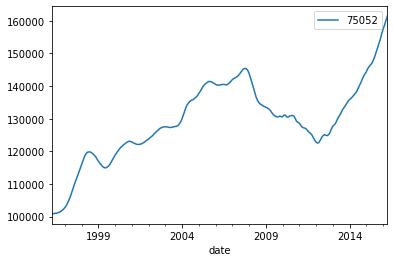

In [55]:
train = df_75052[:-24]
test = df_75052[241:]
train.plot();

In [56]:
print(f"""Train date range: {train.idxmin()} to {train.idxmax()}\n\n
Test date range: {test.idxmin()} to {test.idxmax()}
""")

Train date range: 75052   1996-04-01
dtype: datetime64[ns] to 75052   2016-04-01
dtype: datetime64[ns]


Test date range: 75052   2016-05-01
dtype: datetime64[ns] to 75052   2018-04-01
dtype: datetime64[ns]



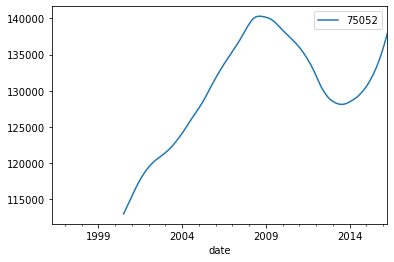

In [57]:
roll_mean = train.rolling(window=52).mean()
roll_mean.plot();

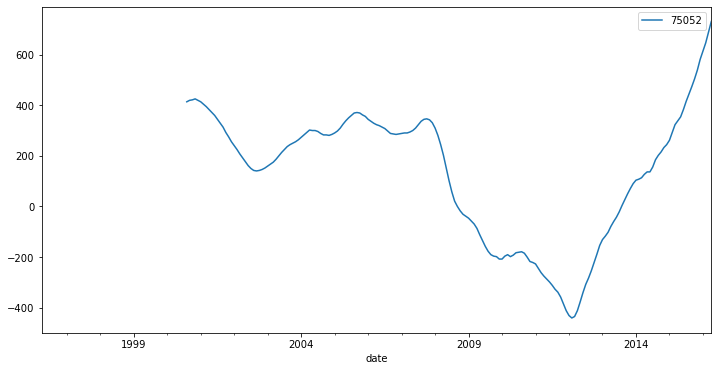

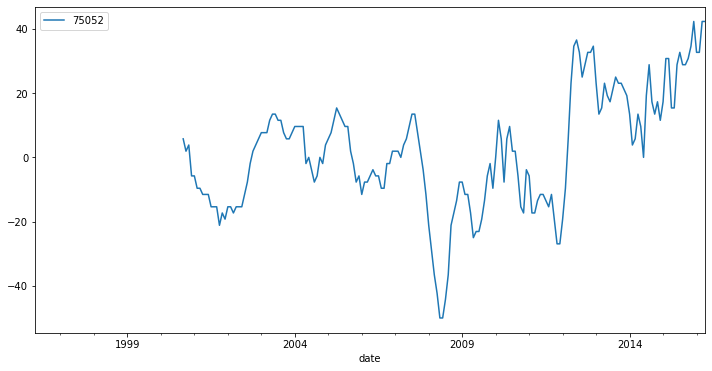

In [58]:
# Apply a 1st order difference to the time series and plot the rolling mean

rm_diff_1 = roll_mean.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6));

**Stationarity Check** 
> We can see that after adding rolling_mean and differencing twice, the Dickey Fuller test improved. We will test out an ARIMA model and SARIMAX to see which performs better.  

In [59]:
print(stationarity_check(df_75052))
print(stationarity_check(rm_diff_2.dropna()))

Results of Dickey-Fuller Test: 

Test Statistic                   0.765594
p-value                          0.991060
#Lags Used                       6.000000
Number of Observations Used    258.000000
Critical Value (1%)             -3.455953
Critical Value (5%)             -2.872809
Critical Value (10%)            -2.572775
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                  -2.682298
p-value                          0.077152
#Lags Used                       3.000000
Number of Observations Used    184.000000
Critical Value (1%)             -3.466398
Critical Value (5%)             -2.877380
Critical Value (10%)            -2.575214
dtype: float64
None


**ARIMA Model Results**

In [60]:
model = arima_results(endog = train, test = test, order=[0,1,0])

NotImplementedError: 

**SARIMAX Model Train and Test Results**

 Train RMSE: 7662.560129714389
 Test RMSE: 18483.76579797575
 Summary:                                      SARIMAX Results                                      
Dep. Variable:                              75052   No. Observations:                  241
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 52)   Log Likelihood               -1543.707
Date:                            Thu, 07 Oct 2021   AIC                           3093.414
Time:                                    23:30:10   BIC                           3103.123
Sample:                                04-01-1996   HQIC                          3097.348
                                     - 04-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1106      0.005     21.246

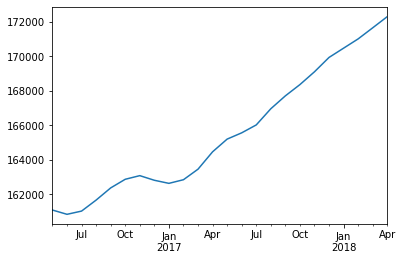

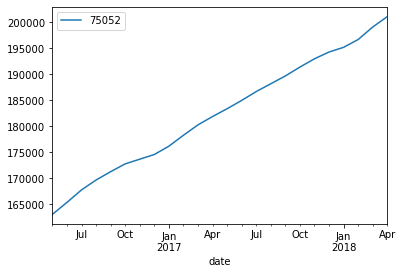

In [61]:
# set print_ts_metrics equal to model, then feed that model to plot_predictions
model = sarimax_results(endog=train, test=test, order=[1,1,0], seasonal_order=[1,1,0,52])
plot_preds_sarimax(test, model);

## 75104

In [ ]:
df_75104 = pd.DataFrame(df_prices[75104][df_prices[75104].notnull()]).astype(int) 
df_75104['value'] = df_75104[75104] 
df_75104.drop(df_75104.columns[np.r_[1]], axis=1, inplace=True)

In [ ]:
train = df_75104[:-24]
test = df_75104[241:]
train.plot();

In [ ]:
roll_mean = train.rolling(window=52).mean()
roll_mean.plot();

In [ ]:
rm_diff_1 = roll_mean.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6));

**Stationarity Check** 
> We can see that after adding rolling_mean and differencing twice, the Dickey Fuller test improved. We will test out an ARIMA model and SARIMAX to see which performs better. 

In [ ]:
print(stationarity_check(df_75104))
print(stationarity_check(rm_diff_2.dropna()))

**ARIMA Model Results**

In [ ]:
model_train = arima_results(train,test,  order=[0,1,0])


**SARIMAX Model Results**

In [ ]:
model = sarimax_results(endog=train, test=test, order=[2,1,1], seasonal_order=[1,1,0,52])
plot_preds_sarimax(test, model);

## 76108

In [ ]:
df_76108 = pd.DataFrame(df_prices[76108][df_prices[76108].notnull()]).astype(int) 
df_76108['value'] = df_76108[76108] 
df_76108.drop(df_76108.columns[np.r_[1]], axis=1, inplace=True)

In [ ]:
train = df_76108[:-24]
test = df_76108[241:]
train.plot();

In [ ]:
roll_mean = train.rolling(window=52).mean()
roll_mean.plot();

In [ ]:
rm_diff_1 = roll_mean.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6));

**Stationarity Check** 
> We can see that after adding rolling_mean and differencing twice, the Dickey Fuller test improved. We will test out an ARIMA model and SARIMAX to see which performs better. 

In [ ]:
print(stationarity_check(df_75104))
print(stationarity_check(rm_diff_2.dropna()))

**ARIMA Model Results**

In [ ]:
model_train = arima_results(test, train,  order=[0,1,0])

**SARIMAX Model Train and Test Results**

In [ ]:
model = sarimax_results(endog=train, test=test, order=[1,1,1], seasonal_order=[1,1,0,52])
plot_preds_sarimax(test, model);

## 77571

In [ ]:
df_77571 = pd.DataFrame(df_prices[77571][df_prices[77571].notnull()]).astype(int) 
df_77571['value'] = df_77571[77571] 
df_77571.drop(df_77571.columns[np.r_[1]], axis=1, inplace=True)

In [ ]:
train = df_77571[:-24]
test = df_77571[241:]
train.plot();

In [ ]:
roll_mean = train.rolling(window=52).mean()
roll_mean.plot();

In [ ]:
rm_diff_1 = roll_mean.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))

In [ ]:
rm_diff_2 = roll_mean.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6));

**Stationarity Check** 
> We can see that after adding rolling_mean and differencing twice, the Dickey Fuller test improved. We will test out an ARIMA model and SARIMAX to see which performs better. 

In [ ]:
print(stationarity_check(df_77571))
print(stationarity_check(rm_diff_2.dropna()))

**ARIMA Model Results**

In [ ]:
model_train = arima_results(test, train,  order=[0,1,0])

**SARIMAX Model Train and Test Results**

In [ ]:
model = sarimax_results(endog=train, test=test, order=[1,1,0], seasonal_order=[1,1,0,52])
plot_preds_sarimax(test, model);

## 79423

In [ ]:
df_79423 = pd.DataFrame(df_prices[79423][df_prices[79423].notnull()]).astype(int) 
df_79423['value'] = df_79423[79423] 
df_79423.drop(df_79423.columns[np.r_[1]], axis=1, inplace=True)


In [ ]:
train = df_79423[:-24]
test = df_79423[241:]
train.plot();

In [ ]:
roll_mean = train.rolling(window=52).mean()
roll_mean.plot();

In [ ]:
rm_diff_1 = roll_mean.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))

In [ ]:
rm_diff_2 = roll_mean.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6));

**Stationarity Check** 
> We can see that after adding rolling_mean and differencing twice, the Dickey Fuller test improved. We will test out an ARIMA model and SARIMAX to see which performs better. 

In [ ]:
print(stationarity_check(df_79423))
print(stationarity_check(rm_diff_2.dropna()))

**ARIMA Model Train Results**

In [ ]:
model_train = arima_results(test, train,  order=[0,1,0])

**SARIMAX Model Train and Test Results**

In [ ]:
model = sarimax_results(endog=train, test=test, order=[1,1,0], seasonal_order=[1,1,0,52])
plot_preds_sarimax(test, model);

# Visualizations

In [ ]:
df_viz = pd.DataFrame(df_merged.copy())
df_viz['affordability'] = df_viz['value'] - df_viz['median_family_income']/.12
df_viz['affordability_score']  = normalize_data(df_viz['affordability'])
df_viz_5 = df_viz[df_viz['zipcode'].isin(zipcodes)]
df_viz_5

**Average Affordability Score**

In [ ]:
df_afs_tx = df_viz.groupby('date').aggregate({'affordability_score':'median'})
df_afs_tx

In [ ]:
df_afs_5 = pd.DataFrame(df_viz_5[['zipcode','affordability_score']], index=df_viz_5.index)
df_afs_5.reset_index(inplace=True)
df_afs_5 = df_afs_5.pivot('date', 'zipcode', 'affordability_score')
df_afs_5

In [ ]:
df_afs = df_afs_5.merge(df_afs_tx, left_index=True, right_index=True)
df_afs.rename(columns={'affordability_score': 'Texas'}, inplace=True)

In [ ]:
df_afs = df_afs[['Texas', 75052, 75104, 76108, 77571, 79423]]
df_afs

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Average Affordability Score', fontsize=15)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
sns.lineplot(data=df_afs, linewidth=4)
fig.set_size_inches(15, 8);
plt.savefig('images/avg_aff_score')


**Average ROI by Zipcode**

In [ ]:
df_roi_5 = pd.DataFrame(df_viz_5[['zipcode','ROI']], index=df_viz_5.index)
df_roi_5.reset_index(inplace=True)
df_roi_5 = df_roi_5.pivot('date', 'zipcode', 'ROI')


In [ ]:
fig, ax = plt.subplots()
ax.set_title('Average ROI', fontsize=15)
ax.set_xlabel('Zip', fontsize=14)
ax.set_ylabel('ROI', fontsize=14)
sns.barplot(data=df_roi_5, palette= "hls", 
            linewidth=4,order=[75104, 75052,76108,77571,79423]).axhline(df_filtered_iqr['ROI'].mean(),linewidth=5,color='black')
fig.set_size_inches(15, 8)
plt.savefig('images/average_roi')

**Median Home Price**

In [ ]:
df_iqr = df_zip_5.groupby('date').aggregate({'value':'median'})

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Yearly Home Prices', fontsize=15)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Median $', fontsize=14)
sns.lineplot(data=df_iqr, linewidth=4)
fig.set_size_inches(15, 8);
plt.savefig('images/avg_aff_score')

In [ ]:
# # import folium
# import folium

# # this is about the center of Texas per google search
# lat = 31.5
# long = -99.9

# # create base texas map
# tx_map = folium.Map(location=[lat, long],min_lat=df_income['latitude'].min(),max_lat=df_income['latitude'].max(),
#                       min_lon=df_income['longitude'].min(),max_lon=df_income['longitude'].max(),
#                       max_bounds=True,zoom_start=6)

# # plotting our points
# x = df_income['latitude']
# y = df_income['longitude']
# points = list(zip(x, y))
# for p in points:
#     lat = p[0]
#     long = p[1]
#     marker = folium.Circle(radius=5,location=[lat, long],color='green')
#     marker.add_to(tx_map)
    
# # plotting our main zips
# x5 = df_filtered_top_roi['latitude']
# y5 = df_filtered_top_roi['longitude']
# c5 = df_filtered_top_roi['city']
# z5 = df_filtered_top_roi['zipcode']
# main_points = list(zip(x5,y5,c5,z5))
# for p in main_points:
#     lat = p[0]
#     long = p[1]
#     city = p[2]
#     zips = p[3]
#     popup_text = "Zip: {} \n\n City: {}".format(zips, city)
#     popup = folium.Popup(popup_text,parse_html=True)
#     marker = folium.Marker(location=[lat,long], popup=popup)
#     marker.add_to(tx_map)
    
# tx_map